<a href="https://colab.research.google.com/github/hhk54250/Is20f/blob/master/haokai/CGMY-FFT%20and%20calibration3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import numpy as np
from scipy.integrate import quad
import math
from scipy import optimize

import pandas as pd

In [90]:

class FTCall:
    def __init__(self, model):
        self.md = model
        
    #$\psi$ function for carr-madan method
    def psi(self, w, T, alpha):
        o1 = np.exp(-self.md.r*T)
        o1 = o1*self.md.charfun(T, w - (alpha+1)*1j)
        o2 = alpha**2+alpha-w**2+1j*(2*alpha+1.)*w
        return o1/o2
    
    #carr-madan method with damping
    def price_cm(self, K, T, alpha = 1.5):
        k = np.log(K)
        integrand = lambda w: (np.exp(-1j*w*k)*self.psi(w, T, alpha)).real
        integral = quad(integrand, 0, np.inf)[0]
        return np.exp(-alpha*k)/np.pi*integral

In [91]:
class Heston:
    def __init__(self, S0, v0, r, kappa, theta, xi, rho):
        self.S0 = S0
        self.v0 = v0
        self.r = r
        self.kappa = kappa
        self.theta = theta
        self.xi = xi
        self.rho = rho
        
    #char func for ln(S_T) from Ng05
    def charfun(self, T, u):
        t1 = self.kappa - self.rho*self.xi*1j*u
        D = np.sqrt(t1**2+(u**2+1j*u)*self.xi**2)
        G = (t1-D)/(t1+D)
        t2 = 1-G*np.exp(-D*T)
        f1 = np.exp(1j*u*(np.log(self.S0+self.r*T)))
        f2 = np.exp(self.v0*(1-np.exp(-D*T))*(t1-D)/self.xi**2/t2)
        f3 = np.exp(self.kappa*self.theta*(
            T*(t1-D)-2*np.log(t2/(1-G)))/self.xi**2)
        return f1*f2*f3

In [92]:
hes = Heston(100, 0.04, 0.03, 2, 0.04, 0.5, -0.7)
ftc = FTCall(hes)
ans = ftc.price_cm(100, 0.5, alpha = 1.5)
print(
      f'Heston FT price by carr-madan is \n  >> {ans}'
      )
print('(ref. P61 of [Hirsa13])')

Heston FT price by carr-madan is 
  >> 5.112752678867938
(ref. P61 of [Hirsa13])


In [93]:
T = 10
#risk free rate
r = 0
#long term volatility(equiribrium level)
theta = 0.0398
#Mean reversion speed of volatility
kappa = 1.5768
#sigma(volatility of Volatility)
sigma = 0.5751
#rho
rho = -0.5751
#Initial stock price
S0 = 100
#Initial volatility
v0 = 0.0175
def charfun(u):
    T = 10
    #risk free rate
    r = 0
    #long term volatility(equiribrium level)
    theta = 0.0398
    #Mean reversion speed of volatility
    kappa = 1.5768
    #sigma(volatility of Volatility)
    xi = 0.5751
    #rho
    rho = -0.5751
    #Initial stock price
    S0 = 100
    #Initial volatility
    v0 = 0.0175
    t1 = kappa - rho*xi*1j*u
    D = np.sqrt(t1**2+(u**2+1j*u)*xi**2)
    G = (t1-D)/(t1+D)
    t2 = 1-G*np.exp(-D*T)
    f1 = np.exp(1j*u*(np.log(S0+r*T)))
    f2 = np.exp(v0*(1-np.exp(-D*T))*(t1-D)/xi**2/t2)
    f3 = np.exp(kappa*theta*(
        T*(t1-D)-2*np.log(t2/(1-G)))/xi**2)
    return f1*f2*f3
def SimpsonW(N,eta):
    delt = np.zeros(N, dtype=np.float)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = eta*(3 + (-1) ** j - delt) / 3
    return SimpsonW
    
def psi(w, T, alpha, r):
    o1 = np.exp(-r*T)
    o1 = o1*charfun(w - (alpha+1)*1j)
    o2 = alpha**2+alpha-w**2+1j*(2*alpha+1.)*w
    return o1/o2

def Heston_NumpyFFT(S0, K, T):
    k = np.log(K)
    x0 = np.log(S0)
    N =2**10
    alpha=1.5
    
    eta=0.15
    lambda_ = 2 * np.pi / (N *eta)
    beta=x0-lambda_*N/2
    km=np.asarray([beta+i*lambda_ for i in range(N)])
    W=SimpsonW(N,eta)
    v=np.asarray([i*eta for i in range(N)])
    Psi=np.asarray([psi(vj, T, alpha, 0)  for vj in v])
    FFTFunc=Psi*np.exp(-1j*beta*v)*W
    
    
    y=np.fft.fft(FFTFunc).real
    
    
    cT=np.exp(-alpha*km)*y/np.pi
    return cT
Heston_NumpyFFT(100, 80, 10)[514]

18.791154357043478

In [94]:
S0 = 100.0  # index level
N =2**10 
eta=0.15
lambda_ = 2 * np.pi / (N *eta)
x0 = np.log(S0)
beta=x0-lambda_*N/2
k=np.asarray([np.e**(beta+lambda_*n) for n in range(N)])


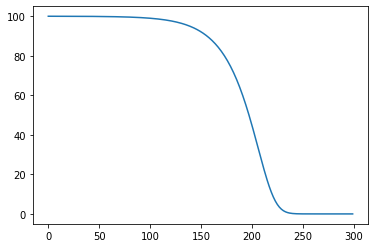

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


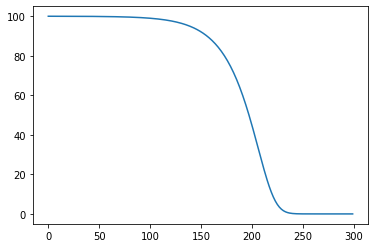

In [95]:
import matplotlib.pyplot as plt
plt.plot(Heston_NumpyFFT(100, 80, 10)[300:600]) 
plt.show()  
hes = Heston(100, 0.0175, 0., 1.5768, 0.0398, 0.5751, -0.5751)
ftc = FTCall(hes)
t=[]
for i in range(300,600):
  t.append(ftc.price_cm(k[i], 10, alpha = 1.5))
plt.plot(t) 
plt.show() 


In [96]:
class FFTCall:
    def __init__(self, model):
        self.md = model
    def psi(self, w, T, alpha):
        o1 = np.exp(-self.md.r*T)
        o1 = o1*self.md.charfun(T, w - (alpha+1)*1j)
        o2 = alpha**2+alpha-w**2+1j*(2*alpha+1.)*w
        return o1/o2
    def SimpsonW(self, N, eta):
        delt = np.zeros(N, dtype=np.float)
        delt[0] = 1
        j = np.arange(1, N + 1, 1)
        SimpsonW = eta*(3 + (-1) ** j - delt) / 3
        return SimpsonW
    def Heston_NumpyFFT(self, T, N, eta, alpha):
        x0 = np.log(self.md.S0)
        lambda_ = 2 * np.pi / (N *eta)
        beta=x0-lambda_*N/2
        km=np.asarray([beta+i*lambda_ for i in range(N)])
        W=self.SimpsonW(N,eta)
        v=np.asarray([i*eta for i in range(N)])
        Psi=np.asarray([self.psi(vj, T, alpha)  for vj in v])
        FFTFunc=Psi*np.exp(-1j*beta*v)*W
        y=np.fft.fft(FFTFunc).real   
        cT=np.exp(-alpha*km)*y/np.pi
        return cT    

In [97]:
class Heston1:
    def __init__(self, S0, v0, r, kappa, theta, xi, rho):
        self.S0 = S0
        self.v0 = v0
        self.r = r
        self.kappa = kappa
        self.theta = theta
        self.xi = xi
        self.rho = rho
    #char func for ln(S_T) from Ng05
    def charfun(self, T, u):
        t1 = self.kappa - self.rho*self.xi*1j*u
        D = np.sqrt(t1**2+(u**2+1j*u)*self.xi**2)
        G = (t1-D)/(t1+D)
        t2 = 1-G*np.exp(-D*T)
        f1 = np.exp(1j*u*(np.log(self.S0+self.r*T)))
        f2 = np.exp(self.v0*(1-np.exp(-D*T))*(t1-D)/self.xi**2/t2)
        f3 = np.exp(self.kappa*self.theta*(
            T*(t1-D)-2*np.log(t2/(1-G)))/self.xi**2)
        return f1*f2*f3

hes = Heston1(100, 0.0175, 0., 1.5768, 0.0398, 0.5751, -0.5751)
fttc = FFTCall(hes)
ans = fttc.Heston_NumpyFFT(10, 2**10, 0.15, alpha = 1.5)
ans[514]
hes = Heston(100, 0.0175, 0., 1.5768, 0.0398, 0.5751, -0.5751)
ftc = FTCall(hes)
t=[]

In [98]:
#speed test


%%time
for i in range(1023):
  t.append(ftc.price_cm(k[i], 10, alpha = 1.5))
t

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


CPU times: user 29.6 s, sys: 6 ms, total: 29.6 s
Wall time: 29.6 s


In [99]:
%%time
fttc.Heston_NumpyFFT(10, 2**10, 0.15, alpha = 1.5)

CPU times: user 36.2 ms, sys: 0 ns, total: 36.2 ms
Wall time: 36 ms


array([-3.27450836e+14, -3.01260253e+14, -2.75800941e+14, ...,
       -2.11086972e-13, -1.96805178e-13, -1.82721879e-13])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  # This is added back by InteractiveShellApp.init_path()


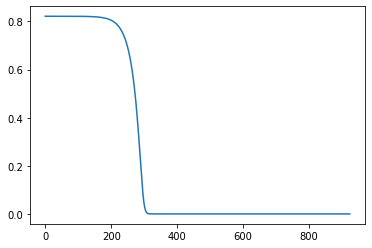

In [100]:
class CGMY:
    def __init__(self, S0, G, Y, C, M, r):
        self.S0 = S0
        self.G = G
        self.Y = Y
        self.C = C
        self.M = M
        self.r = r
    def charfun(self, T, u):
        integrand = lambda w: w**(-(self.Y)-1)*(np.e)**(-w)
        gamma = quad(integrand, 0, np.inf)[0]
        f1 = (np.e)**(self.C*T*gamma*((self.M-1j*u)**self.Y-self.M**self.Y+(self.G+1j*u)**self.Y-self.G**self.Y))
        return f1

CGMY = CGMY(100,5,0.5,2,10,0.03)
ftt2 = FFTCall(CGMY)
ans2 = ftt2.Heston_NumpyFFT(0.5, 2**10, 0.15, alpha = 0.5)

plt.plot(ans2[100:1024]) 
plt.show()  

In [101]:
class CGMY2:
    def __init__(self, S0, G, Y, C, M, r):
        self.S0 = S0
        self.G = G
        self.Y = Y
        self.C = C
        self.M = M
        self.r = r
    def charfun(self, T, u):
        gamma = math.gamma(-(self.Y))
        beta = self.C*(self.G**self.Y)*gamma*((1+1/self.G)**self.Y-1-self.Y/self.G) + self.C*(self.M**self.Y)*gamma*((1-1/self.M)**self.Y-1+self.Y/self.M)
        f1 = (np.e)**(1j*u*np.log(self.S0)+(self.r-beta)*T)
        f2 = (np.e)**(self.C*(self.G**self.Y)*T*gamma*((1+1j*u/self.G)**self.Y-1-1j*u*self.Y/self.G) + self.C*(self.M**self.Y)*T*gamma*((1-1j*u/self.M)**self.Y-1+1j*u*self.Y/self.M))
        return f1*f2

In [102]:
CGMY = CGMY2(100,5,0.5,2,10,0.03)
ftt1 = FFTCall(CGMY)
ans1 = ftt1.Heston_NumpyFFT(0.5, 2**10, 0.15, alpha = 0.5)

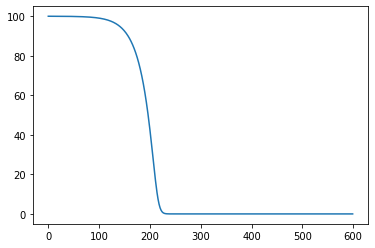

10.725567345057915

In [103]:
plt.plot(ans1[300:900]) 
plt.show()  
ans1[514]

In [104]:
ftc1 = FTCall(CGMY)
ans = ftc1.price_cm(40, 0.5, alpha = 1.5)
ans


62.049226774184774

In [105]:

%%time
market_price = 62.049226774184774

def g(params):
    C,G,M,Y,r = params
    market_price = 91
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3600, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]

minimum2= optimize.fmin(g,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12)

minimum2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 268
         Function evaluations: 568
CPU times: user 18.8 s, sys: 3 ms, total: 18.8 s
Wall time: 18.8 s


In [106]:
CGMY = CGMY2(3638.35,2.73358554,0.10443549,0.48593288,5.66897703,0.01035572)
ftc1 = FTCall(CGMY)
ans = ftc1.price_cm(3600, 1/12, alpha = 1.5)
ans

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


90.99999961269833

In [107]:
%cd~

!git clone https://github.com/hhk54250/IS20.git 
pass

/root
fatal: destination path 'IS20' already exists and is not an empty directory.


In [108]:
%cd IS20
%ls

/root/IS20
'analytical solution of Heston model.ipynb'
'CGMY and implied CGMYr.ipynb'
'data(1).csv'
 Fourier_Transform_Heston_BSM.ipynb
 Heston-FFT2.ipynb
 Heston-FFT.ipynb
 option.csv
'Option value using fast fourier transform.ipynb'
'Option value using fast fourier transform(last version).ipynb'
 README.md
 Untitled13.ipynb


In [109]:
market = pd.read_csv("option.csv")
market_strike = market['1.00']
market_price = market['2']
market_strike

0     3,600.00
1     3,605.00
2     3,610.00
3     3,615.00
4     3,620.00
5     3,625.00
6     3,630.00
7     3,635.00
8     3,640.00
9     3,645.00
10    3,650.00
11    3,655.00
12    3,660.00
13    3,665.00
14    3,670.00
15    3,675.00
16    3,680.00
17    3,685.00
18    3,690.00
19    3,695.00
20    3,700.00
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
30         NaN
31         NaN
Name: 1.00, dtype: object

In [110]:
market_strike

0     3,600.00
1     3,605.00
2     3,610.00
3     3,615.00
4     3,620.00
5     3,625.00
6     3,630.00
7     3,635.00
8     3,640.00
9     3,645.00
10    3,650.00
11    3,655.00
12    3,660.00
13    3,665.00
14    3,670.00
15    3,675.00
16    3,680.00
17    3,685.00
18    3,690.00
19    3,695.00
20    3,700.00
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
30         NaN
31         NaN
Name: 1.00, dtype: object

In [111]:
class FTCall1:
    def __init__(self, model):
        self.md = model
        
    #$\psi$ function for carr-madan method
    def psi(self, w, T, shit):
        o1 = np.exp(-self.md.r*T)
        o1 = o1*self.md.charfun(T, w - (shit+1)*1j)
        o2 = shit**2+shit-w**2+1j*(2*shit+1.)*w
        return o1/o2
    
    #carr-madan method with damping
    def price_cm(self, K, T, shit = 1.5):
        k = np.log(K)
        integrand = lambda w: (np.exp(-1j*w*k)*self.psi(w, T, shit)).real
        integral = quad(integrand, 0, np.inf)[0]
        return np.exp(-shit*k)/np.pi*integral

In [87]:
def g1(params):
    C,G,M,Y,r = params
    market_price = 91
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3600, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2=[]
minimum2.append(optimize.fmin(g1,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g2(params):
    C,G,M,Y,r = params
    market_price = 87.5
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3605.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g2,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g3(params):
    C,G,M,Y,r = params
    market_price = 84.1
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3610.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g3,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g4(params):
    C,G,M,Y,r = params
    market_price = 80.0
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3615.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g4,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g5(params):
    C,G,M,Y,r = params
    market_price = 77.6
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3620.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g5,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g6(params):
    C,G,M,Y,r = params
    market_price = 74.1
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3625.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g6,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g7(params):
    C,G,M,Y,r = params
    market_price = 71.4
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3630.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g7,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g8(params):
    C,G,M,Y,r = params
    market_price = 68.4
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3635.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g8,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g9(params):
    C,G,M,Y,r = params
    market_price = 65.4
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3640.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g9,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g10(params):
    C,G,M,Y,r = params
    market_price = 62.5
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3645.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g10,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g11(params):
    C,G,M,Y,r = params
    market_price = 59.7
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3650.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g11,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g12(params):
    C,G,M,Y,r = params
    market_price = 57.0
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3655.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g12,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g13(params):
    C,G,M,Y,r = params
    market_price = 54.3
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3660.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g13,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g14(params):
    C,G,M,Y,r = params
    market_price = 51.4
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3665.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g14,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g15(params):
    C,G,M,Y,r = params
    market_price = 49.2
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3670.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g15,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g16(params):
    C,G,M,Y,r = params
    market_price = 46.9
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3675.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g16,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g17(params):
    C,G,M,Y,r = params
    market_price = 44.4
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3680.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g17,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g18(params):
    C,G,M,Y,r = params
    market_price = 42.2
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3685.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g18,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g19(params):
    C,G,M,Y,r = params
    market_price = 40.0
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3690.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g19,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g20(params):
    C,G,M,Y,r = params
    market_price = 37.8
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3695.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g20,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

def g21(params):
    C,G,M,Y,r = params
    market_price = 35.7
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(3700.00, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2.append(optimize.fmin(g21,guess_g,maxfun=400000000000,maxiter=400000000000,ftol=1e-50,xtol=1e-12))

minimum2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 268
         Function evaluations: 568
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 260
         Function evaluations: 533
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 262
         Function evaluations: 537
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 264
         Function evaluations: 539
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 259
         Function evaluations: 528


KeyboardInterrupt: ignored

In [119]:
market_strike

0     3,600.00
1     3,605.00
2     3,610.00
3     3,615.00
4     3,620.00
5     3,625.00
6     3,630.00
7     3,635.00
8     3,640.00
9     3,645.00
10    3,650.00
11    3,655.00
12    3,660.00
13    3,665.00
14    3,670.00
15    3,675.00
16    3,680.00
17    3,685.00
18    3,690.00
19    3,695.00
20    3,700.00
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
30         NaN
31         NaN
Name: 1.00, dtype: object

In [121]:
market1=[]
market2=[3600,3605,3610,3615,3620,3625,3630,3635,3640,3645,3650,3655,3660,3665,3670,3675,3680,3685,3690,3695,3700]
for i in range(20):
  market1.append(market_price[i])


21

In [138]:



def g1(params,a,b):
    C,G,M,Y,r = params
    market_price = a
    CGMY = CGMY2(3638.35,M,Y,C,G,r)
    ftc1 = FTCall(CGMY)
    ans = ftc1.price_cm(b, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g=[1,5,2,0.1,0.01]
minimum2=[]
for i in range(20):
  minimum2.append(optimize.fmin(g1,guess_g,args=(market1[i],market2[i],),maxfun=400000000,maxiter=400000000,ftol=1e-6,xtol=1e-6))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 141
         Function evaluations: 279
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 130
         Function evaluations: 251
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 126
         Function evaluations: 246
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 127
         Function evaluations: 246
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 124
         Function evaluations: 243
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 170
         Function evaluations: 322
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 132
         Function evaluations: 283
Optimization termina

In [144]:
minimum2

[array([0.48593288, 5.6689769 , 2.73358554, 0.10443549, 0.01035572]),
 array([0.49263644, 5.6935854 , 2.71582608, 0.10377684, 0.01036788]),
 array([0.49840296, 5.70008185, 2.69114759, 0.10321111, 0.0103736 ]),
 array([0.50085566, 5.72661028, 2.68673642, 0.10272919, 0.01036941]),
 array([0.51309106, 5.68872255, 2.65449082, 0.10278709, 0.01041174]),
 array([0.51942403, 5.70664279, 2.6461976 , 0.10284351, 0.01040041]),
 array([0.51894768, 5.5200997 , 2.58265967, 0.10353799, 0.01048721]),
 array([0.53644464, 5.59191668, 2.60549525, 0.10274278, 0.01037482]),
 array([0.54248744, 5.63885026, 2.57686202, 0.10312198, 0.01042552]),
 array([0.54832237, 5.539578  , 2.56359712, 0.10492417, 0.01043688]),
 array([0.56389035, 5.56878931, 2.57301693, 0.10322553, 0.01040257]),
 array([0.56682747, 5.48848725, 2.54251018, 0.10541287, 0.01034573]),
 array([0.57297879, 5.456392  , 2.51594403, 0.10480135, 0.01039161]),
 array([0.58584762, 5.45496583, 2.5343068 , 0.10462018, 0.01031621]),
 array([0.59452365, 

In [152]:
def g22(params,a,c):
  C,G,M,Y,r = params
  CGMY = CGMY2(3638.35,M,Y,C,G,r)
  ftc1 = FTCall(CGMY)
  b = 0
  for i in range(20):
    market_price = a[i]
    b = b + (market_price - ftc1.price_cm(c[i], 1/12, alpha = 1.5)**2)
  d = np.sqrt(b)
  return d

minimum3 = []
guess_g=[1,5,2,0.1,0.01]

minimum3.append(optimize.fmin(g22,guess_g,args=(market1,market2,),maxfun=40000,maxiter=40000,ftol=1e-2,xtol=1e-2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


KeyboardInterrupt: ignored

In [153]:
CGMY = CGMY2(3638.35,2.56359712,0.10492417,0.54832237,5.539578,0.01043688)
ftc1 = FTCall(CGMY)
ans = []
for i in range(20):
  ans.append(ftc1.price_cm(market2[i], 1/12, alpha = 1.5))
ans

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


[100.85662917940435,
 96.5088111474378,
 92.17704734543871,
 87.86503732616377,
 83.57433984426582,
 79.30364817244612,
 75.0589306804773,
 70.84094400785874,
 66.65354827309561,
 62.50000002724352,
 58.38635593023267,
 54.31964382972905,
 50.31071819859372,
 46.37691699640679,
 42.54902621497515,
 38.9124805295851,
 36.83417617927008,
 35.75654841951859,
 34.83295346388432,
 34.00280857885506]

In [154]:
market1

[91.0,
 87.5,
 84.1,
 80.0,
 77.6,
 74.1,
 71.4,
 68.4,
 65.4,
 62.5,
 59.7,
 57.0,
 54.3,
 51.4,
 49.2,
 46.9,
 44.4,
 42.2,
 40.0,
 37.8]